# LSTM AutoEncoder
## Trying to find contextual anomalies within chair sensor dataset which are/are indicators of full body extensor spasms

In [171]:
# Import required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model, load_model
import seaborn as sns
import datetime
import os.path

### Point of analysis: Data Filtered
A chunk of data has been removed where the back rest of the chair has been locked. If the back sensor data is not be used then perhaps this can be returned for use in training/testing? 

In [18]:
# Retrieve data and place with pd dataframe
source_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/patient/patient_data.csv'
dataframe = pd.read_csv(source_file_path, parse_dates=['datetime'])
print(dataframe.head())

   action  subject  frame  index  back_angle  left_angle  right_angle  \
0     NaN      NaN    NaN    0.0    0.424307    0.600144     0.237863   
1     NaN      NaN    NaN    1.0    0.456290    0.596542     0.223615   
2     NaN      NaN    NaN    2.0    0.488273    0.592939     0.223615   
3     NaN      NaN    NaN    3.0    0.530917    0.585735     0.224274   
4     NaN      NaN    NaN    4.0    0.573561    0.571326     0.223615   

                 datetime  back_1der  left_1der  right_1der     back_2der  \
0 2011-12-01 11:04:05.000   0.028175   0.000360   -0.010737  4.568992e-03   
1 2011-12-01 11:04:05.050   0.032744  -0.003242   -0.006760  4.568992e-03   
2 2011-12-01 11:04:05.100   0.037313  -0.006844   -0.002784  4.568992e-03   
3 2011-12-01 11:04:05.150   0.038380  -0.012248    0.000079 -2.775558e-16   
4 2011-12-01 11:04:05.200   0.037313  -0.017651   -0.000079 -4.568992e-03   

   left_2der  right_2der  
0  -0.003602    0.003977  
1  -0.003602    0.003977  
2  -0.003602    0

### Point of analysis: Chosen Sensors
For the moment I have elected to go for left and right hip angles (+ their derivatives) and exclude the back angle
### Point of analysis: Use of one or more derivatives
I have decided to use the 1st and 2nd derivatives as a way to hopefully unlock insight. How does this effect the model?

In [19]:
# Obtaining only the required columns
sensors = ['left_angle', 'right_angle', 'left_1der', 'right_1der', 'left_2der', 'right_2der']
df = dataframe.loc[:,sensors]
#, 'back_1der', 'left_1der', 'right_1der', 'back_2der', 'left_2der', 'right_2der'

df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'datetime'])
# df.set_index('Date', inplace=True)
print(df.head())

print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

   left_angle  right_angle  left_1der  right_1der  left_2der  right_2der  \
0    0.600144     0.237863   0.000360   -0.010737  -0.003602    0.003977   
1    0.596542     0.223615  -0.003242   -0.006760  -0.003602    0.003977   
2    0.592939     0.223615  -0.006844   -0.002784  -0.003602    0.003977   
3    0.585735     0.224274  -0.012248    0.000079  -0.007205   -0.000075   
4    0.571326     0.223615  -0.017651   -0.000079  -0.005661   -0.000226   

                     Date  
0 2011-12-01 11:04:05.000  
1 2011-12-01 11:04:05.050  
2 2011-12-01 11:04:05.100  
3 2011-12-01 11:04:05.150  
4 2011-12-01 11:04:05.200  
Start date is:  2011-12-01 11:04:05
End date is:  2011-12-01 11:38:19.300000


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

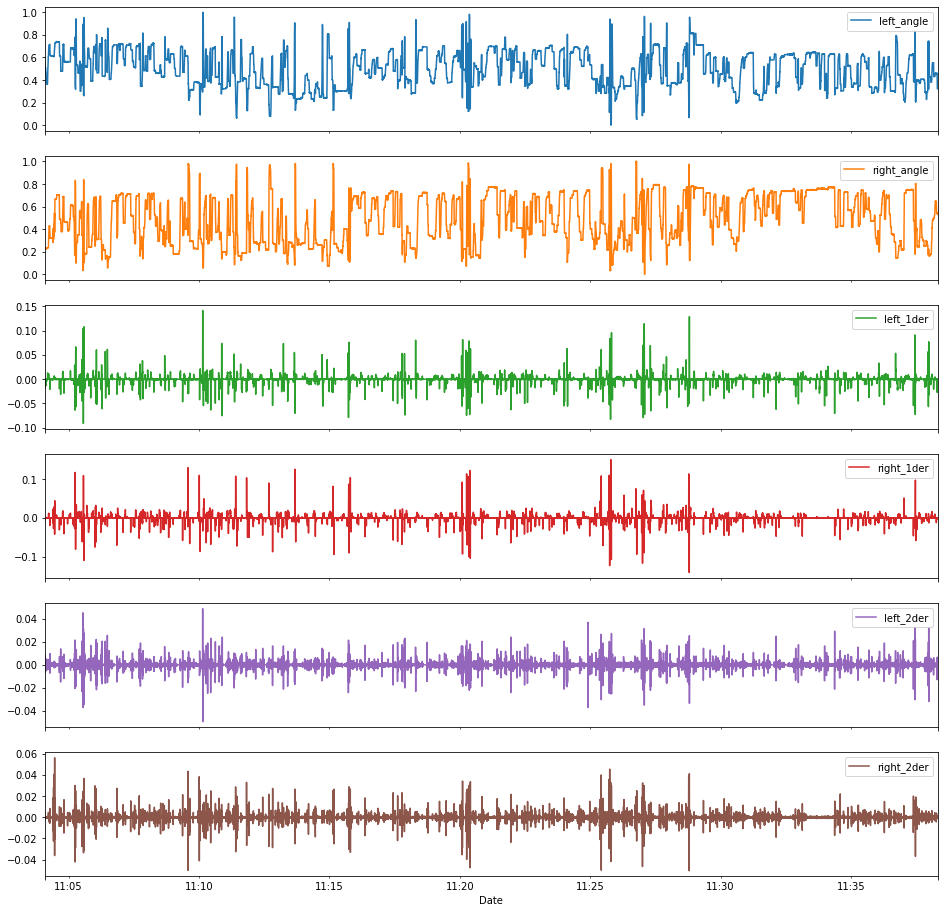

In [53]:
# Initial plot of data
df.plot(subplots=True, figsize=(16, 16), x='Date')# 

In [21]:
# Split test and train data
train, test = df.loc[df['Date'] <= '2011-12-01 11:38:00'], df.loc[df['Date'] > '2011-12-01 11:38:00']

In [22]:
# scaler = StandardScaler()
# scaler = scaler.fit(train[['back_angle']])

# train['back_angle'] = scaler.transform(train[['back_angle']])
# print(test)
# test['back_angle'] = scaler.transform(test[['back_angle']])
print("We might need to do some additional normalising or scaling here")
# train

We might need to do some additional normalising or scaling here


### Point of analysis: Window size
This should effect the ability to recognise longer contextual anomalies, as well as in realtime?
Currently I have 40 which is equivalent to 2 seconds @ 20Hz

In [23]:
seq_size = 40  # Number of time steps to look back 

In [24]:
def to_sequences(x, y, seq_size=1):
    '''Function to return windowed versions'''
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

In [25]:
# Slice data in to windows
trainX, trainY = to_sequences(train[sensors], train[sensors], seq_size)
testX, testY = to_sequences(test[sensors], test[sensors], seq_size)

In [26]:
print(f'Number of training samples: {trainX.shape}')
print(f'Number of test samples: {trainY.shape}')

Number of training samples: (40661, 40, 6)
Number of test samples: (40661, 6)


### Point of analysis: Network Architecture - I found this architecture in examples but not sure if it is inappropriate or what the thinking is behind it

In [172]:
# # Define AutoEncoder architecture
# model = Sequential()
# # Encoder
# model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(LSTM(64, activation='relu', return_sequences=False))

# model.add(RepeatVector(trainX.shape[1]))
# #Decoder
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(trainX.shape[2])))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

# for layer in model.layers:
#     print(layer.input_shape)

In [173]:
# now = datetime.datetime.now()
# time_code = now.strftime("%H%M%S_%m%d")
time_code = '115243_0415'

In [174]:
file_name = f'{time_code}-model.h5'


In [175]:
# Fit the model
if os.path.isfile(file_name):
    model = load_model(file_name)
    print(f"Loaded {file_name}")
else:
    # Define AutoEncoder architecture
    model = Sequential()
    # Encoder
    model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(64, activation='relu', return_sequences=False))

    model.add(RepeatVector(trainX.shape[1]))
    #Decoder
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(TimeDistributed(Dense(trainX.shape[2])))
    model.compile(optimizer='adam', loss='mae')
    callback = EarlyStopping(monitor='loss', patience=2)
    history = model.fit(trainX, trainX, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[callback])
    model.save(file_name)
    print(f"Saved as {file_name}")

    # Show the history of loss
    plt.figure(figsize=(16, 8))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Model Training - {time_code}")
    plt.legend()
    diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
    diag_file_name = f'training-{time_code}.png'
    plt.savefig(f'{diag_file_path}{diag_file_name}')

model.summary()
for layer in model.layers:
    print(layer.input_shape)


Loaded 115243_0415-model.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 40, 128)           69120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 40, 64)            33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 40, 128)           98816     
_________________________________________________________________
dropout_3 (Dropout)       

In [143]:
trainPredict = model.predict(trainX)

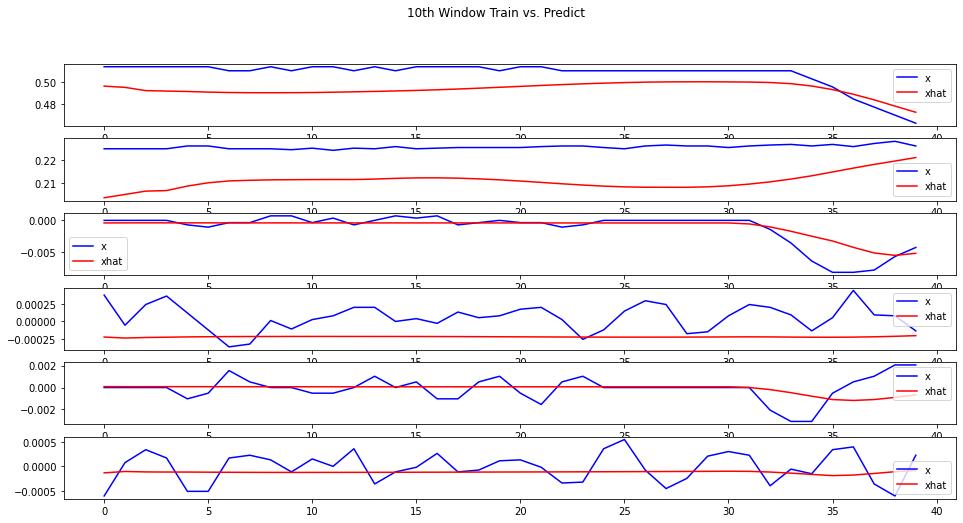

In [144]:
no_feats = len(sensors)
example = 10
train_plot = trainX[example]
predict_plot = trainPredict[example]
x_plot = list(range(seq_size))
fig, axes = plt.subplots(no_feats, 1, figsize=(16, 8))

fig.suptitle(f"{example}th Window Train vs. Predict")

for sensor in range(no_feats):
    sns.lineplot(x=x_plot, y=train_plot[:,sensor], color='b', ax=axes[sensor], label='x')
    sns.lineplot(x=x_plot, y=predict_plot[:,sensor], color='r', ax=axes[sensor], label='xhat')

plt.legend()


### Point of analysis: Error computation
At the moment on the mae is being used in order to rank anomaly likelihood - refer to some papers that discuss other techniques such as TadGAN

In [145]:
error = np.abs(trainPredict - trainX)
trainMAE = np.max(error, axis=1)
trainMAE

array([[0.05263608, 0.01897245, 0.01193874, 0.01048893, 0.00771569,
        0.00396119],
       [0.044308  , 0.02197226, 0.00839703, 0.00651504, 0.00735122,
        0.00393191],
       [0.03919081, 0.022272  , 0.00349394, 0.00254476, 0.00744229,
        0.00390095],
       ...,
       [0.13834927, 0.04795062, 0.0658261 , 0.01215665, 0.03240501,
        0.00551935],
       [0.13332726, 0.04794925, 0.06605033, 0.01217728, 0.03238757,
        0.00552887],
       [0.12616874, 0.0488232 , 0.0645521 , 0.0121629 , 0.03240124,
        0.00553537]])

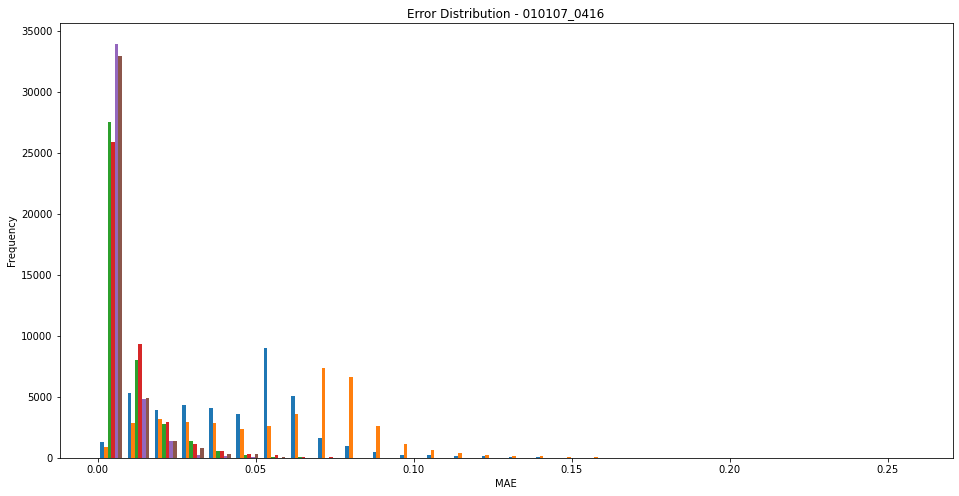

In [146]:
plt.figure(figsize=(16, 8))
_ = plt.hist(trainMAE, bins=30)
plt.xlabel("MAE")
plt.ylabel("Frequency")
plt.title(f"Error Distribution - {time_code}")
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-hist-{time_code}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')

### Point of analysis: Threshold computation
At the moment it is fixed and set at 80% of the max. Can this be improved?

In [147]:
thresh_pct = 0.8
max_trainMAE = [thresh_pct * np.amax(trainMAE)] * len(train[seq_size:])  #or Define 90% value of max as threshold.
max_trainMAE = np.array(max_trainMAE).flatten()
print(max_trainMAE[0])

0.20686717823534267


In [148]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(train[seq_size:])
anomaly_df['trainMAE'] = np.max(trainMAE, axis=1)
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['trainMAE'] > anomaly_df['max_trainMAE']
# anomaly_df['back_angle'] = test[seq_size:]['back_angle']

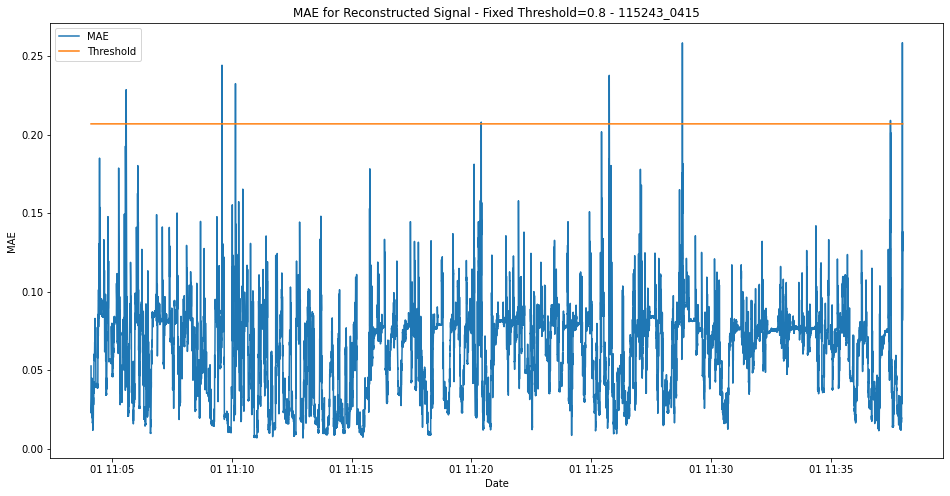

In [152]:
#Plot testMAE vs max_trainMAE
plt.figure(figsize=(16, 8))
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['trainMAE'], label='MAE')
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'], label='Threshold')
plt.xlabel("Date")
plt.ylabel("MAE")
plt.title(f"MAE for Reconstructed Signal - Fixed Threshold={thresh_pct} - 115243_0415")
plt.legend()
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-thresh-{thresh_pct}-115243_0415.png'
# diag_file_name = f'error-thresh-{thresh_pct}-{time_code}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [153]:
print(anomalies)

       left_angle  right_angle  left_1der  right_1der     left_2der  \
1803     0.484870     0.168194   0.094380   -0.063245  2.778921e-02   
1804     0.600144     0.120580   0.108069   -0.032387  6.175381e-03   
6599     0.549712     0.746702  -0.015130    0.128496 -1.543845e-02   
6600     0.528098     0.890501  -0.024496    0.098021 -1.029230e-02   
6601     0.484870     0.967018  -0.029899    0.055145  1.543845e-03   
7275     1.000000     0.078760   0.031340   -0.014274 -3.756690e-02   
7276     1.000000     0.073219   0.005403   -0.005620 -1.595307e-02   
19589    0.297550     0.270580   0.052450   -0.057744  1.646768e-03   
26000    0.326369     0.288127   0.049171   -0.108232  6.020996e-03   
26001    0.373199     0.184433   0.058069   -0.076042  1.276245e-02   
26002    0.438040     0.139050   0.069885   -0.038298  1.337999e-02   
26005    0.686599     0.125726   0.081772   -0.004011 -4.631536e-03   
29663    0.111671     0.436675   0.043300   -0.129683  2.202552e-02   
29664 

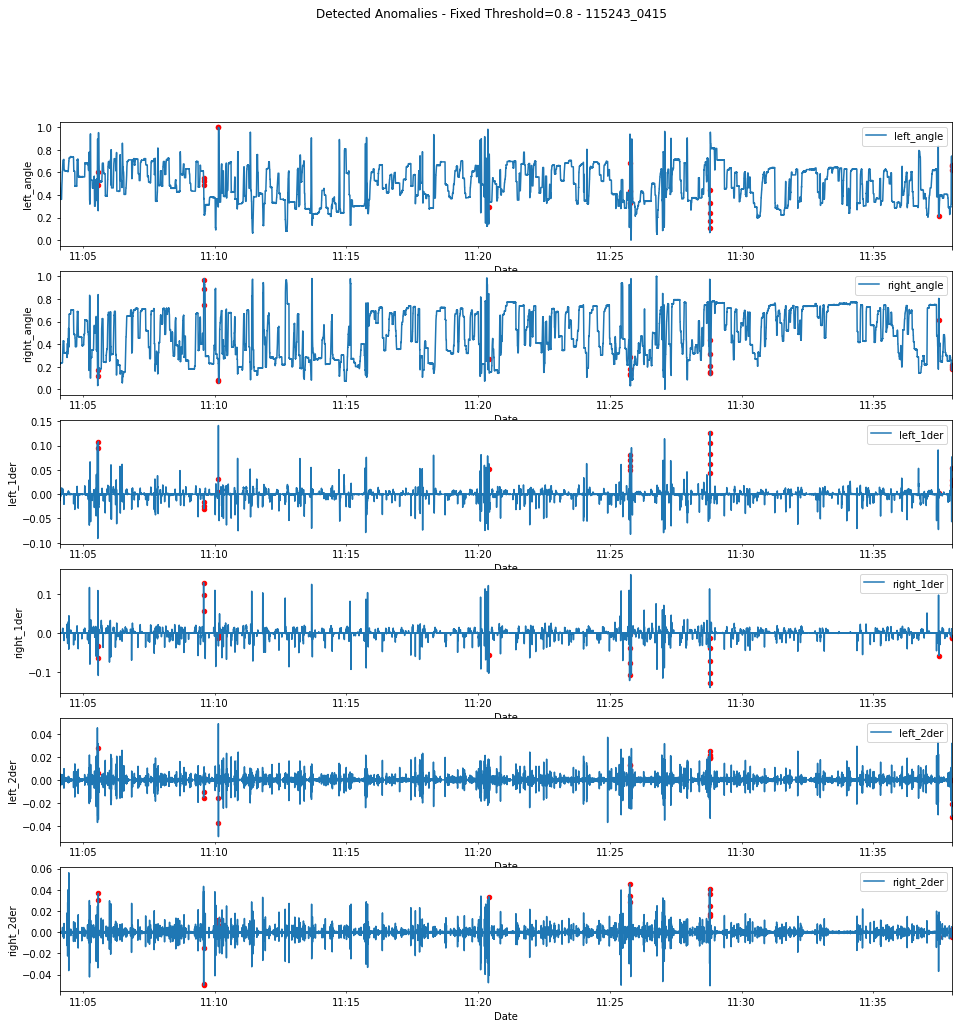

In [155]:
no_feats = len(sensors)
fig, axes = plt.subplots(no_feats, 1, figsize=(16, 16))
for x in range(no_feats):
    anomaly_df.plot(kind='line', x='Date', y=sensors[x], ax=axes[x])
    anomalies.plot(kind='scatter', x='Date', y=sensors[x], color='r', ax=axes[x])

# fig.suptitle(f"Detected Anomalies - Fixed Threshold={thresh_pct} - {time_code}")
fig.suptitle(f"Detected Anomalies - Fixed Threshold={thresh_pct} - 115243_0415")
plt.legend()
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
# diag_file_name = f'error-thresh-{thresh_pct}-{time_code}.png'
diag_file_name = f'ad-{thresh_pct}-115243_0415.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')

## Adding the control data to the training set

In [188]:
file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/control/'
numpy_name = 'control_data.npy'
controlX = np.load(f'{file_path}{numpy_name}')
controlX.shape

(9825, 40, 6)

In [192]:
augX = np.append(trainX, controlX, axis=0)
augX.shape
new_numpy_name = 'aug_train_data_ws40.npy'
np.save(f'{file_path}{new_numpy_name}', augX)
print(f"Numpy array saved as: {file_path}{new_numpy_name}")

Numpy array saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/control/aug_train_data_ws40.npy


In [176]:
# now = datetime.datetime.now()
# time_code = now.strftime("%H%M%S_%m%d")
time_code1 = '010107_0416'

In [177]:
file_name1 = f'{time_code1}-model.h5'

In [178]:
# Fit the model
if os.path.isfile(file_name1):
    augmodel = load_model(file_name1)
    print(f"Loaded {file_name1}")
else:
    # Define AutoEncoder architecture
    augmodel = Sequential()
    # Encoder
    augmodel.add(LSTM(128, activation='relu', input_shape=(augX.shape[1], augX.shape[2]), return_sequences=True))
    augmodel.add(Dropout(rate=0.2))
    augmodel.add(LSTM(64, activation='relu', return_sequences=False))

    augmodel.add(RepeatVector(augX.shape[1]))
    #Decoder
    augmodel.add(LSTM(64, activation='relu', return_sequences=True))
    augmodel.add(LSTM(128, activation='relu', return_sequences=True))
    augmodel.add(Dropout(rate=0.2))
    augmodel.add(TimeDistributed(Dense(augX.shape[2])))
    augmodel.compile(optimizer='adam', loss='mae')


    callback = EarlyStopping(monitor='loss', patience=2)
    history = augmodel.fit(augX, augX, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[callback])
    augmodel.save(file_name1)
    print(f"Saved as {file_name1}")

   # Show the history of loss
    plt.figure(figsize=(16, 8))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Augmented Model Training - {time_code1}")
    plt.legend()
    diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
    diag_file_name = f'training-{time_code1}.png'
    plt.savefig(f'{diag_file_path}{diag_file_name}')

augmodel.summary()
for layer in augmodel.layers:
    print(layer.input_shape)

Loaded 010107_0416-model.h5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 40, 128)           69120     
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 40, 64)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 40, 64)            33024     
_________________________________________________________________
lstm_11 (LSTM)               (None, 40, 128)           98816     
_________________________________________________________________
dropout_5 (Dropout)       

In [179]:
augPredict = augmodel.predict(trainX)


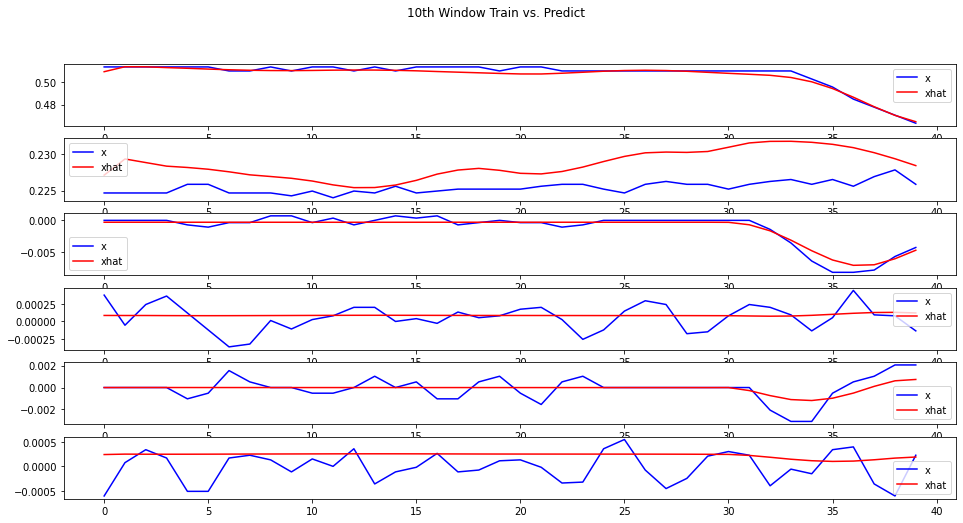

In [180]:
no_feats = len(sensors)
example = 10
train_plot = trainX[example]
predict_plot = augPredict[example]
x_plot = list(range(seq_size))
fig, axes = plt.subplots(no_feats, 1, figsize=(16, 8))

fig.suptitle(f"{example}th Window Train vs. Predict")

for sensor in range(no_feats):
    sns.lineplot(x=x_plot, y=train_plot[:,sensor], color='b', ax=axes[sensor], label='x')
    sns.lineplot(x=x_plot, y=predict_plot[:,sensor], color='r', ax=axes[sensor], label='xhat')

plt.legend()

In [181]:
error1 = np.abs(augPredict - trainX)
trainMAE1 = np.max(error, axis=1)
trainMAE1

array([[0.05263608, 0.01897245, 0.01193874, 0.01048893, 0.00771569,
        0.00396119],
       [0.044308  , 0.02197226, 0.00839703, 0.00651504, 0.00735122,
        0.00393191],
       [0.03919081, 0.022272  , 0.00349394, 0.00254476, 0.00744229,
        0.00390095],
       ...,
       [0.13834927, 0.04795062, 0.0658261 , 0.01215665, 0.03240501,
        0.00551935],
       [0.13332726, 0.04794925, 0.06605033, 0.01217728, 0.03238757,
        0.00552887],
       [0.12616874, 0.0488232 , 0.0645521 , 0.0121629 , 0.03240124,
        0.00553537]])

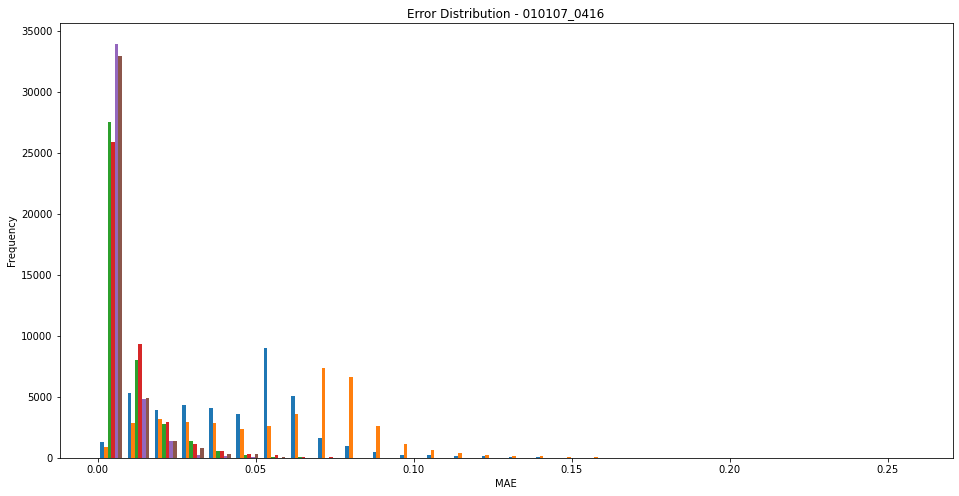

In [182]:
plt.figure(figsize=(16, 8))
_ = plt.hist(trainMAE1, bins=30)
plt.xlabel("MAE")
plt.ylabel("Frequency")
plt.title(f"Error Distribution - {time_code1}")
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-hist-{time_code1}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')

In [183]:
thresh_pct1 = 0.8
max_trainMAE1 = [thresh_pct1 * np.amax(trainMAE1)] * len(train[seq_size:])  #or Define 90% value of max as threshold.
max_trainMAE1 = np.array(max_trainMAE1).flatten()
print(max_trainMAE1[0])

0.20686717823534267


In [184]:
#Capture all details in a DataFrame for easy plotting
anomaly_df1 = pd.DataFrame(train[seq_size:])
anomaly_df1['trainMAE'] = np.max(trainMAE1, axis=1)
anomaly_df1['max_trainMAE'] = max_trainMAE1
anomaly_df1['anomaly'] = anomaly_df1['trainMAE'] > anomaly_df1['max_trainMAE']
# anomaly_df['back_angle'] = test[seq_size:]['back_angle']

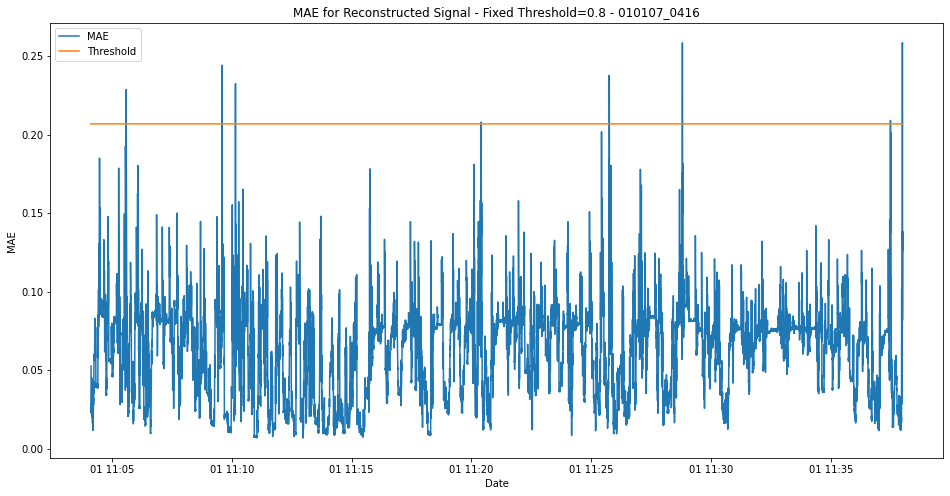

In [185]:
#Plot testMAE vs max_trainMAE
plt.figure(figsize=(16, 8))
sns.lineplot(x=anomaly_df1['Date'], y=anomaly_df1['trainMAE'], label='MAE')
sns.lineplot(x=anomaly_df1['Date'], y=anomaly_df1['max_trainMAE'], label='Threshold')
plt.xlabel("Date")
plt.ylabel("MAE")
plt.title(f"MAE for Reconstructed Signal - Fixed Threshold={thresh_pct1} - {time_code1}")
plt.legend()
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
diag_file_name = f'error-thresh-{thresh_pct1}-{time_code1}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')
anomalies = anomaly_df1.loc[anomaly_df1['anomaly'] == True]

In [186]:
print(anomalies)

       left_angle  right_angle  left_1der  right_1der     left_2der  \
1803     0.484870     0.168194   0.094380   -0.063245  2.778921e-02   
1804     0.600144     0.120580   0.108069   -0.032387  6.175381e-03   
6599     0.549712     0.746702  -0.015130    0.128496 -1.543845e-02   
6600     0.528098     0.890501  -0.024496    0.098021 -1.029230e-02   
6601     0.484870     0.967018  -0.029899    0.055145  1.543845e-03   
7275     1.000000     0.078760   0.031340   -0.014274 -3.756690e-02   
7276     1.000000     0.073219   0.005403   -0.005620 -1.595307e-02   
19589    0.297550     0.270580   0.052450   -0.057744  1.646768e-03   
26000    0.326369     0.288127   0.049171   -0.108232  6.020996e-03   
26001    0.373199     0.184433   0.058069   -0.076042  1.276245e-02   
26002    0.438040     0.139050   0.069885   -0.038298  1.337999e-02   
26005    0.686599     0.125726   0.081772   -0.004011 -4.631536e-03   
29663    0.111671     0.436675   0.043300   -0.129683  2.202552e-02   
29664 

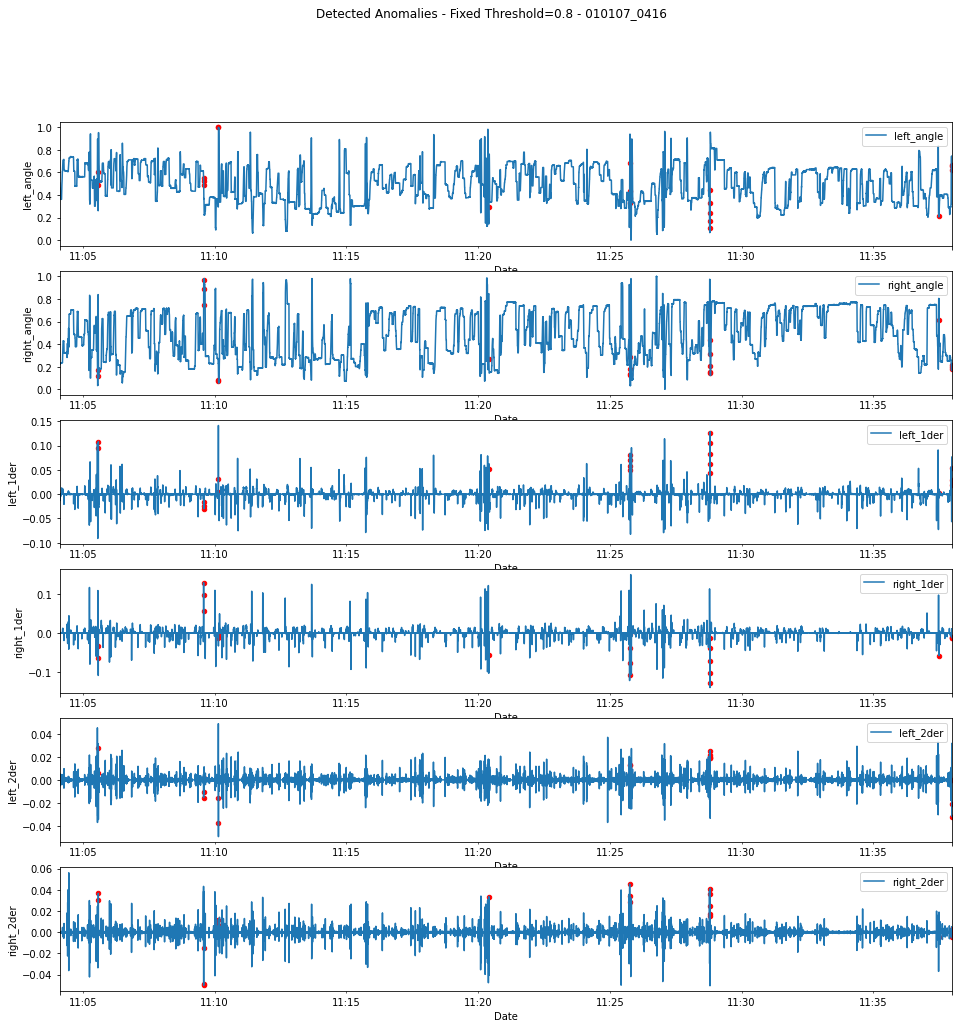

In [187]:
no_feats = len(sensors)
fig, axes = plt.subplots(no_feats, 1, figsize=(16, 16))
for x in range(no_feats):
    anomaly_df1.plot(kind='line', x='Date', y=sensors[x], ax=axes[x])
    anomalies.plot(kind='scatter', x='Date', y=sensors[x], color='r', ax=axes[x])
# fig.suptitle(f"Detected Anomalies - Fixed Threshold={thresh_pct} - {time_code}")
fig.suptitle(f"Detected Anomalies - Fixed Threshold={thresh_pct1} - {time_code1}")
plt.legend()
diag_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
# diag_file_name = f'error-thresh-{thresh_pct}-{time_code}.png'
diag_file_name = f'ad-{thresh_pct1}-{time_code1}.png'
plt.savefig(f'{diag_file_path}{diag_file_name}')